<a href="https://colab.research.google.com/github/abhilash1910/AI-Geometric-Learning/blob/master/Chapter_2_Understanding_the_data/Isomap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Isomap

Isomap is a non linear reduction algorithm which uses distance nearness for the dimension reduction. It works by determining graph based distance from a KNN induced neighborhood of datapoints. Distance measures like Euclidean Dijkstra are used before the standard metric MDS algorithm. 
After the distance matrix is created, it is translated via the double centering mechanism mentioned in [MDS](https://github.com/abhilash1910/AI-Geometric-Learning/blob/master/Chapter_2_Understanding_the_data/InformationGeometry_MDS.ipynb) . The double centered matrix is then used for eigen value decomposition.


KNN is used initially to create and connect each node to the closest K neighbors. Note that we do not need to use Euclidean distance but can and should try many different distances to see which has the best results for your particular dataset. Often in high dimensions, Euclidean distance breaks down and we must start searching elsewhere. 
Thresholding can also be used to determine the distance connections between the points. If two points are within our distance threshold, then they are connected, otherwise the distance between the two nodes is set to infinity. We can tune our threshold so that each node has some minimum number of connections, which is what we'll use in our example. The following image provides a reference for this:

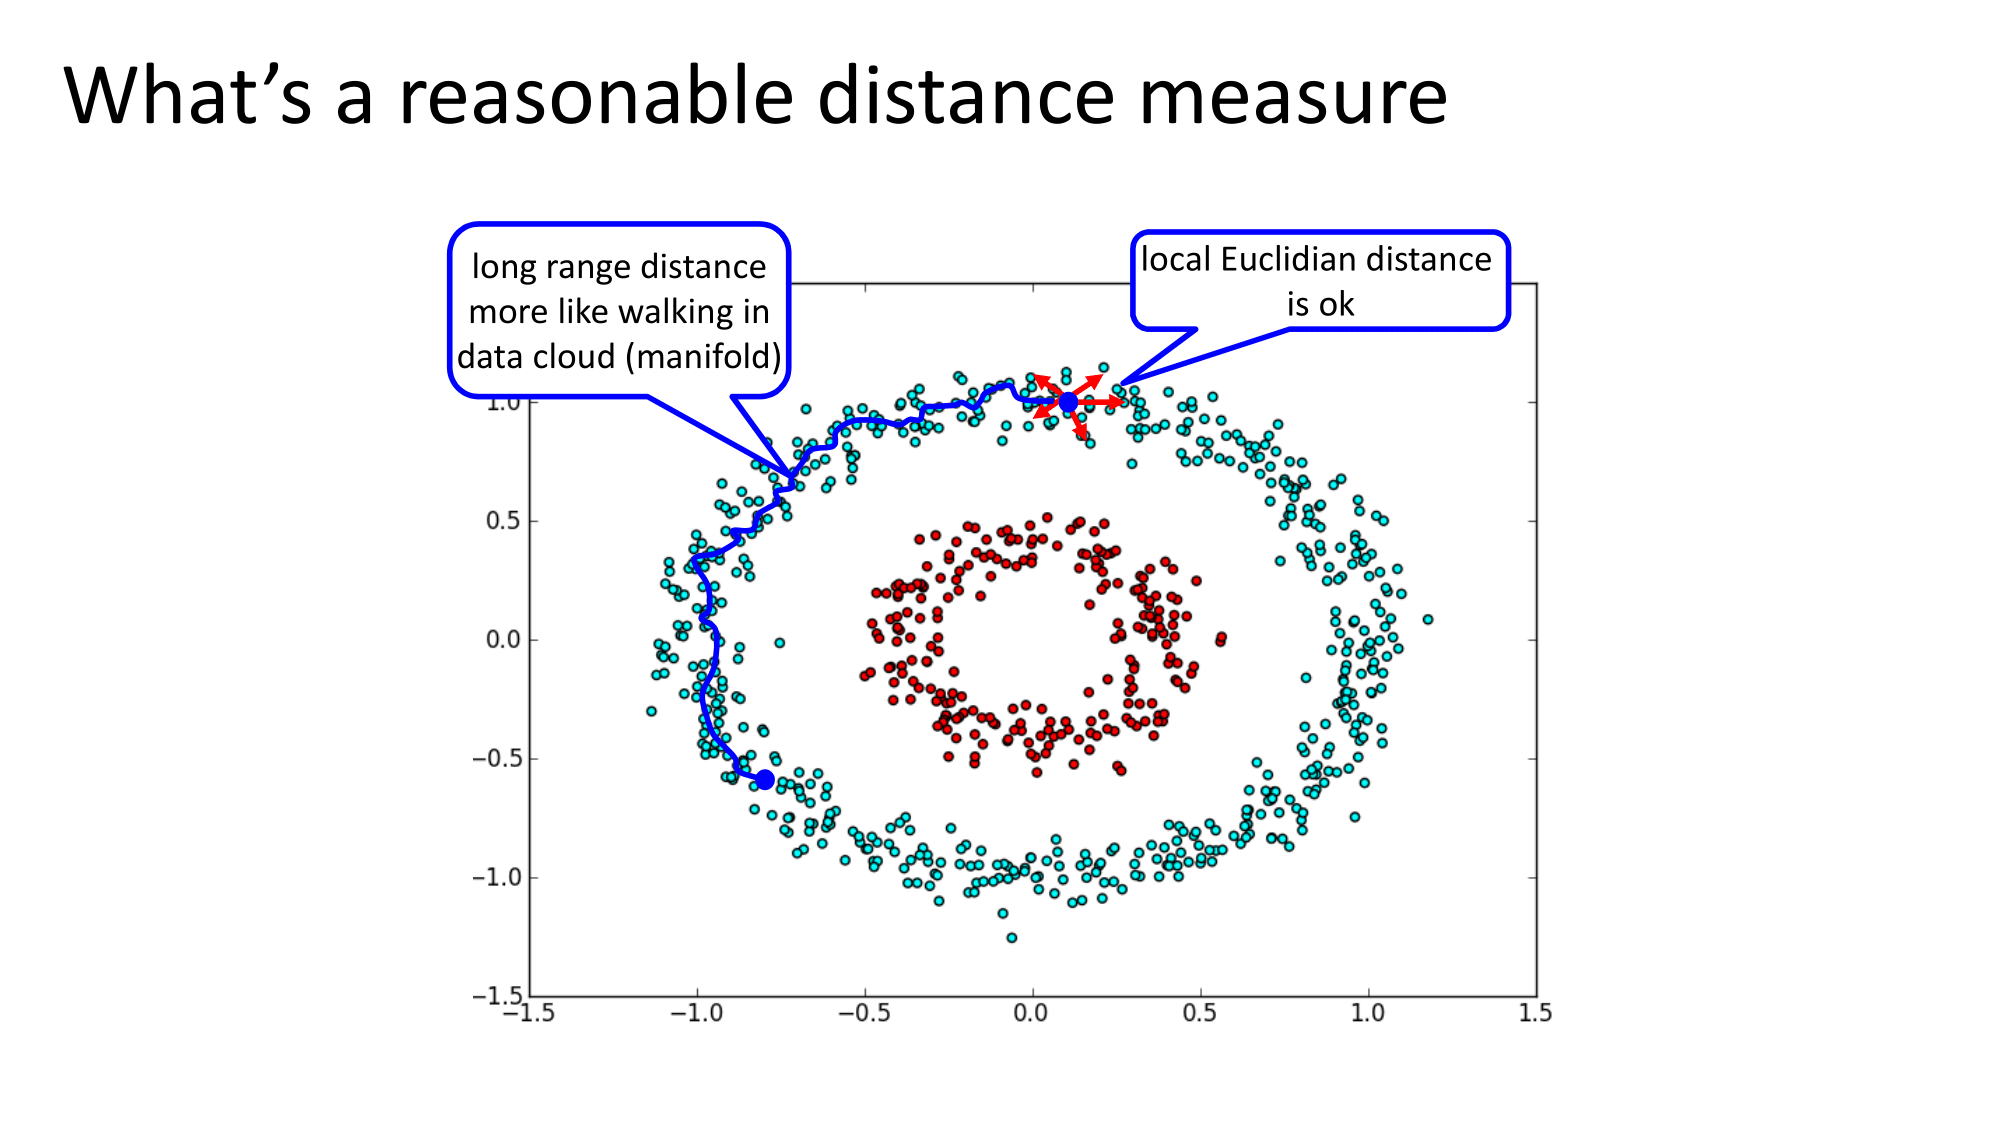




### Implementing Isomap on Tanenbaum Facial Data

We will create our distance matrix which has the shortest path between each point and every other point. This matrix will be symmetric since we are not creating a directed graph. This is the main difference between ISOMAP and a linear approach. We will allow the path to travel through the shape of the data showing the points are related even though they might not actually be "close" regarding our distance metric.

Finally, we take an eigenvalue decomposition of the kernel matrix. The largest N (in our case 2) eigenvalues and their corresponding eigenvectors are the projections of our original data into the new plain. Since eigenvectors are all linearly independent thus, we will avoid collision

The example chosen [here](https://benalexkeen.com/isomap-for-dimensionality-reduction-in-python/) is from Tanenbaum et al (face pose detection) These images are 64*64 pixels in dimension and will be reduced by non linear Isomap to 2 dimension. By running isomap, we can see that the images are now projected in 2d space and similar images are closer together. Upon increasing the iterations of the graph convergence better results are obtained. In the code sample, we have induced 100 iterations for the initial graph distance convergence.

For libraries, we require [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html) and scipy. 

In [2]:
!pip install sklearn

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function graph_shortest_path is deprecated; `graph_shortest_path` is deprecated in 1.0 (renaming of 0.25) and will be removed in 1.2. Use `scipy.sparse.csgraph.shortest_path` instead.
  warnings.warn(msg, category=FutureWarning)


Eigen Values:[[ 1.06126306e-04  7.40522363e-05]
 [-8.32432524e-05  7.06521099e-05]
 [ 1.53989702e-04  6.74558598e-05]
 ...
 [-3.19989452e-04  9.51915666e-05]
 [-4.96158110e-05 -4.08639403e-04]
 [-1.77892572e-04 -9.18064545e-05]]
Isomap has completed


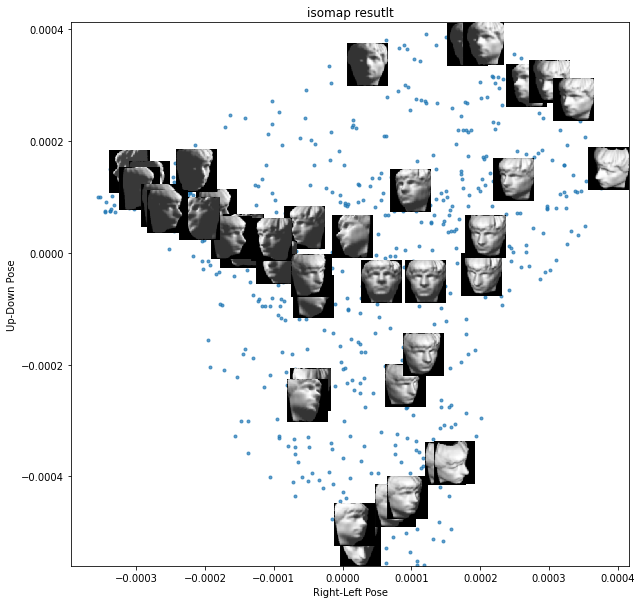

In [2]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.spatial.distance import cdist
from sklearn.utils.graph import graph_shortest_path
import scipy.io

class Isomap():
  def __init__(self,data,n_components,eps):
    #initialization of data , number of dimensions and episodes of convergence of shortest path
    self.data=data
    self.eps=eps
    self.n_components=n_components

  def graph_distance(self):
    """
    We compute the weighted adjacency matrix A from the given data points.  Points
    are considered neighbors if they are within epsilon of each other.  Distance
    between points will be calculated using SciPy's cdist which will
    compute the D matrix for us. 
    """

    n, m = self.data.shape
    dist = cdist(self.data.T, self.data.T, metric="euclidean")
    self.adj_matrix =  np.zeros((m, m)) + np.inf
    bln = dist < self.eps
    self.adj_matrix[bln] = dist[bln]
    dijkstra_path = graph_shortest_path(self.adj_matrix)
    return dijkstra_path

  def one_centering(self,n):
    #double centering using  subtraction from identity matrix for translational invariance
    I=np.identity(n)
    O=np.ones((n,n))
    self.H=I-O/n
    return self.H

  def double_centering(self,D):
    #extended part of the double centering method
    self.D=D
    self.H=-self.H.dot(self.D**2).dot(self.H)/2
    return self.H

  def eigen_decompose(self,eigen_matrix):
    """
    Here we take the eigen matrix to decompose into eigen values/vectors 
    Same as in MDS 
    """
    
    self.c=eigen_matrix
    evals, evecs = linalg.eig(self.c)
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    evals = evals[:self.n_components] 
    evecs = evecs[:, :self.n_components]
    z = evecs.dot(np.diag(evals**(-1/2)))
    return z.real


def plot_graph(components, x, my_title="Facial Netowork Chart", filename="faces.png"):
    #Plotter to plot the similarity feature map
    #Adapted from : http://benalexkeen.com/isomap-for-dimensionality-reduction-in-python/
    n, m = x.shape
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111)
    ax.set_title(my_title)
    ax.set_xlabel('Component: 1')
    ax.set_ylabel('Component: 2')

    # Show 40 of the images ont the plot
    x_size = (max(components[:, 0]) - min(components[:, 0])) * 0.08
    y_size = (max(components[:, 1]) - min(components[:, 1])) * 0.08

    for i in range(40):
        img_num = np.random.randint(0, m)
        x0 = components[img_num, 0] - (x_size / 2.)
        y0 = components[img_num, 1] - (y_size / 2.)
        x1 = components[img_num, 0] + (x_size / 2.)
        y1 = components[img_num, 1] + (y_size / 2.)
        img = x[:, img_num].reshape(64, 64).T
        ax.imshow(img, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

    # Show 2D components plot
    ax.scatter(components[:, 0], components[:, 1], marker='.',alpha=0.7)
    ax.set_ylabel('Up-Down Pose')
    ax.set_xlabel('Right-Left Pose')

    plt.savefig(filename)
    return None

if __name__ == "__main__":
    """
    The isomap is loaded into get the feature maps.
    Isomap works by creating a shortest distance path matrix , and then applying
    double centering on it to get the transposed matrix. This matrix is then used
    for eigen vector decomposition (silimar to MDS) . The decomposed vectors are
    sorted and top 'n' dimensions are extracted as in MDS.
    """
    #load the feature map (While running the kernel isomap.mat should be loaded)
    img = scipy.io.loadmat('isomap.mat')
    isomap_mat=img['images']
    #hyperparams
    n_components=2
    eps=100
    #Create Isomap object
    isomap_object=Isomap(isomap_mat,n_components,eps)
    D=isomap_object.graph_distance()
    n,m=D.shape
    H=isomap_object.one_centering(m)
    eigen_matrix=isomap_object.double_centering(D)
    #Extract the eigen values
    z_real=isomap_object.eigen_decompose(eigen_matrix)
    print(f"Eigen Values:{z_real}")
    #Plot the graph
    plot_graph(z_real, x=isomap_mat, my_title="isomap resutlt")
    print(f"Isomap has completed")
    

    